In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Reading data from Sqltie database
import sqlite3

In [3]:
conn = sqlite3.connect(r'database.sqlite')
type(conn)

sqlite3.Connection

In [4]:
reviews_df = pd.read_sql_query('SELECT * FROM reviews', conn)

In [5]:
reviews_df.shape

(568454, 10)

#### Data Preparation

In [6]:
reviews_df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
reviews_df['HelpfulnessNumerator'] > reviews_df['HelpfulnessDenominator'] 
# Invalid row

0         False
1         False
2         False
3         False
4         False
          ...  
568449    False
568450    False
568451    False
568452    False
568453    False
Length: 568454, dtype: bool

In [8]:
reviews_df[reviews_df['HelpfulnessNumerator'] > reviews_df['HelpfulnessDenominator'] ]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [9]:
valid_reviews = reviews_df[reviews_df['HelpfulnessNumerator'] <= reviews_df['HelpfulnessDenominator'] ]

In [10]:
# Remove duplicate rows

valid_reviews.duplicated(['UserId','ProfileName','Time','Text']).sum()

174521

In [11]:
new_valid = valid_reviews.drop_duplicates(subset=['UserId','ProfileName','Time','Text'])

In [12]:
new_valid.shape

(393931, 10)

In [13]:
new_valid.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [14]:
new_valid['Time'] = pd.to_datetime(new_valid['Time'], unit='s')

C:\Users\Than Aung Kyaw\AppData\Local\Temp\ipykernel_6476\2261918460.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_valid['Time'] = pd.to_datetime(new_valid['Time'], unit='s')


In [15]:
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

#### Analyse to what user Amazon can recommend more products?

In [16]:
new_valid.columns 

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [17]:
new_valid['ProfileName'].nunique()

218418

In [18]:
new_valid['UserId'].nunique()

256059

In [19]:
recommend_df = new_valid.groupby(['UserId']).agg({
    'Summary':'count',
    'Text':'count',
    'Score':'mean',
    'ProductId':'count'
}).sort_values(by='ProductId', ascending=False)

In [20]:
recommend_df.head()

,Summary,Text,Score,ProductId
UserId,,,,
AY12DBB0U420B,329,329,4.659574,329
A3OXHLG6DIBRW8,278,278,4.546763,278
A281NPSIMI1C2R,259,259,4.787645,259
A1YUL9PCJR3JTY,214,214,4.621495,214
A1Z54EM24Y40LL,211,211,4.383886,211


In [21]:
recommend_df.columns=['Summary_count','Text_count','Avg_score','Purchased_product_count']

In [22]:
recommend_df.head()

,Summary_count,Text_count,Avg_score,Purchased_product_count
UserId,,,,
AY12DBB0U420B,329,329,4.659574,329
A3OXHLG6DIBRW8,278,278,4.546763,278
A281NPSIMI1C2R,259,259,4.787645,259
A1YUL9PCJR3JTY,214,214,4.621495,214
A1Z54EM24Y40LL,211,211,4.383886,211


In [24]:
recommend_df.index[0:10]

Index(['AY12DBB0U420B', 'A3OXHLG6DIBRW8', 'A281NPSIMI1C2R', 'A1YUL9PCJR3JTY',
       'A1Z54EM24Y40LL', 'A2MUGFV2TDQ47K', 'A3D6OI36USYOU1', 'AZV26LP92E6WU',
       'AKMEY1BSHSDG7', 'A2GEZJHBV92EVR'],
      dtype='object', name='UserId')

In [25]:
recommend_df['Purchased_product_count'][0:10].values

array([329, 278, 259, 214, 211, 161, 146, 129, 119, 118], dtype=int64)

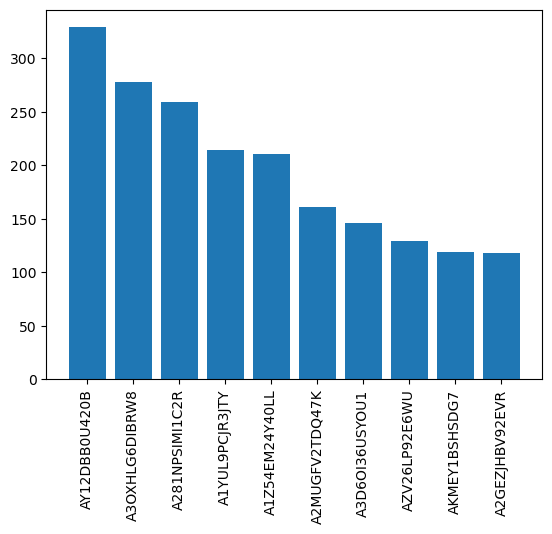

In [31]:
x = recommend_df.index[0:10]
y = recommend_df['Purchased_product_count'][0:10].values

plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

#### Which product has good number of reviews?

In [33]:
prod_count = new_valid['ProductId'].value_counts().to_frame()

In [34]:
prod_count

,ProductId
B007JFMH8M,912
B002QWP89S,630
B003B3OOPA,622
B001EO5Q64,566
B0013NUGDE,558
...,...
B002DNX4GO,1
B000FM2YU2,1
B001M1VA32,1
B009858H6M,1


In [37]:
# ProductIds of products sold over 500 unit
prod_count[prod_count['ProductId']>500].index

Index(['B007JFMH8M', 'B002QWP89S', 'B003B3OOPA', 'B001EO5Q64', 'B0013NUGDE',
       'B000KV61FC', 'B000UBD88A', 'B000NMJWZO', 'B005K4Q37A', 'B0090X8IPM',
       'B005ZBZLT4'],
      dtype='object')

In [39]:
freq_prod_ids = prod_count[prod_count['ProductId']>500].index
freq_prod_ids

Index(['B007JFMH8M', 'B002QWP89S', 'B003B3OOPA', 'B001EO5Q64', 'B0013NUGDE',
       'B000KV61FC', 'B000UBD88A', 'B000NMJWZO', 'B005K4Q37A', 'B0090X8IPM',
       'B005ZBZLT4'],
      dtype='object')

In [41]:
freq_prod_df = new_valid[new_valid['ProductId'].isin(freq_prod_ids)]

In [42]:
freq_prod_df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

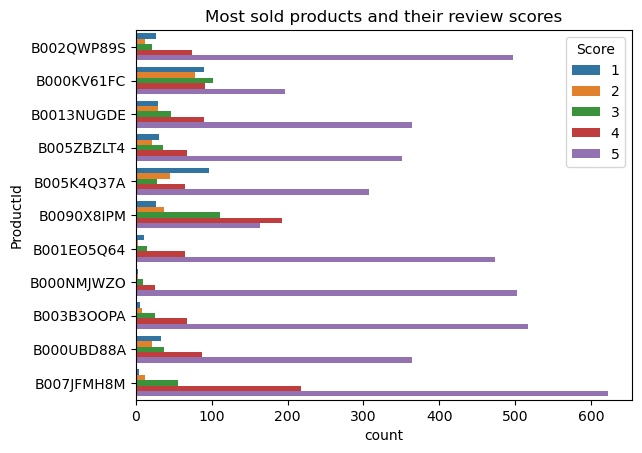

In [48]:
sns.countplot(y='ProductId', data=freq_prod_df, hue='Score')
plt.title('Most sold products and their review scores')
plt.show()

#### Is there any difference between behaviour of frequent viewers and not frequent viewers?

In [49]:
new_valid.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [50]:
new_valid['UserId'].value_counts()

AY12DBB0U420B     329
A3OXHLG6DIBRW8    278
A281NPSIMI1C2R    259
A1YUL9PCJR3JTY    214
A1Z54EM24Y40LL    211
                 ... 
AAQPR1MSRXKTU       1
AGO81Z6PZSF7P       1
ALA84XWMTQBFT       1
A1G9DK8EUR36JC      1
A3LGQPJCZVL9UC      1
Name: UserId, Length: 256059, dtype: int64

In [51]:
x = new_valid['UserId'].value_counts()

In [52]:
new_valid['viewer_type'] = new_valid['UserId'].apply(lambda user: "Frequent" if x[user]>50 else "Not Frequent")

In [53]:
new_valid['viewer_type']

0         Not Frequent
1         Not Frequent
2         Not Frequent
3         Not Frequent
4         Not Frequent
              ...     
568449    Not Frequent
568450    Not Frequent
568451    Not Frequent
568452    Not Frequent
568453    Not Frequent
Name: viewer_type, Length: 393931, dtype: object

In [54]:
freq_df = new_valid[new_valid['viewer_type'] == 'Frequent']
not_freq_df = new_valid[new_valid['viewer_type'] == 'Not Frequent']

In [55]:
freq_df['Score'].value_counts()

5    5765
4    1979
3     897
2     368
1     349
Name: Score, dtype: int64

In [56]:
# Percentage
freq_df['Score'].value_counts() / len(freq_df) * 100

5    61.605044
4    21.147681
3     9.585381
2     3.932464
1     3.729429
Name: Score, dtype: float64

In [57]:
not_freq_df['Score'].value_counts() / len(not_freq_df) * 100

5    63.757986
4    14.071191
1     9.349850
3     7.507547
2     5.313426
Name: Score, dtype: float64

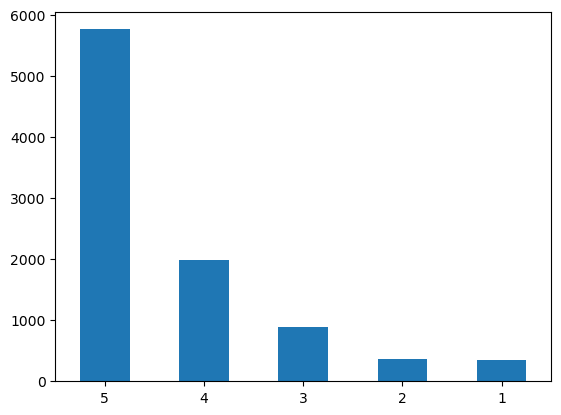

In [64]:
freq_df['Score'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

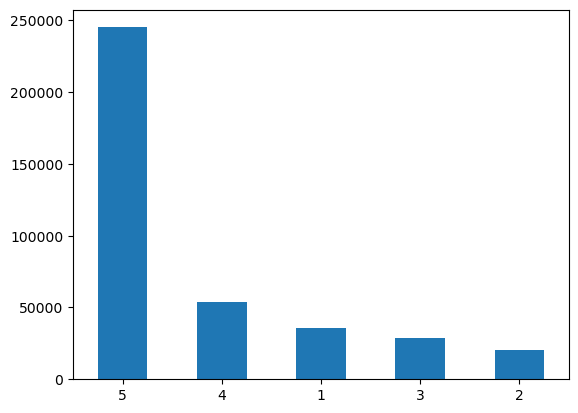

In [65]:
not_freq_df['Score'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

#### Are frequent users more verbose?

In [66]:
new_valid.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'viewer_type'],
      dtype='object')

In [68]:
new_valid[['UserId','ProductId','Text']]

,UserId,ProductId,Text
0,A3SGXH7AUHU8GW,B001E4KFG0,I have bought several of the Vitality canned d...
1,A1D87F6ZCVE5NK,B00813GRG4,Product arrived labeled as Jumbo Salted Peanut...
2,ABXLMWJIXXAIN,B000LQOCH0,This is a confection that has been around a fe...
3,A395BORC6FGVXV,B000UA0QIQ,If you are looking for the secret ingredient i...
4,A1UQRSCLF8GW1T,B006K2ZZ7K,Great taffy at a great price. There was a wid...
...,...,...,...
568449,A28KG5XORO54AY,B001EO7N10,Great for sesame chicken..this is a good if no...
568450,A3I8AFVPEE8KI5,B003S1WTCU,I'm disappointed with the flavor. The chocolat...
568451,A121AA1GQV751Z,B004I613EE,"These stars are small, so you can give 10-15 o..."
568452,A3IBEVCTXKNOH,B004I613EE,These are the BEST treats for training and rew...


In [69]:
new_valid['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [71]:
len(new_valid['Text'][0].split(' '))

49

In [73]:
def calculate_length(text):
    return len(text.split(' '))

In [74]:
new_valid['Text_length'] = new_valid['Text'].apply(calculate_length)

In [76]:
freq_data = new_valid[new_valid['viewer_type'] == 'Frequent']
not_freq_data = new_valid[new_valid['viewer_type'] == 'Not Frequent']

In [77]:
not_freq_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,viewer_type,Text_length
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,Not Frequent,49
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Frequent,31
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,Not Frequent,99
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,Not Frequent,43
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,Not Frequent,30
...,...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,2011-03-09,Will not do without,Great for sesame chicken..this is a good if no...,Not Frequent,26
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,2012-03-09,disappointed,I'm disappointed with the flavor. The chocolat...,Not Frequent,46
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,2012-02-21,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",Not Frequent,71
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,2012-03-13,Favorite Training and reward treat,These are the BEST treats for training and rew...,Not Frequent,37


(0.0, 600.0)

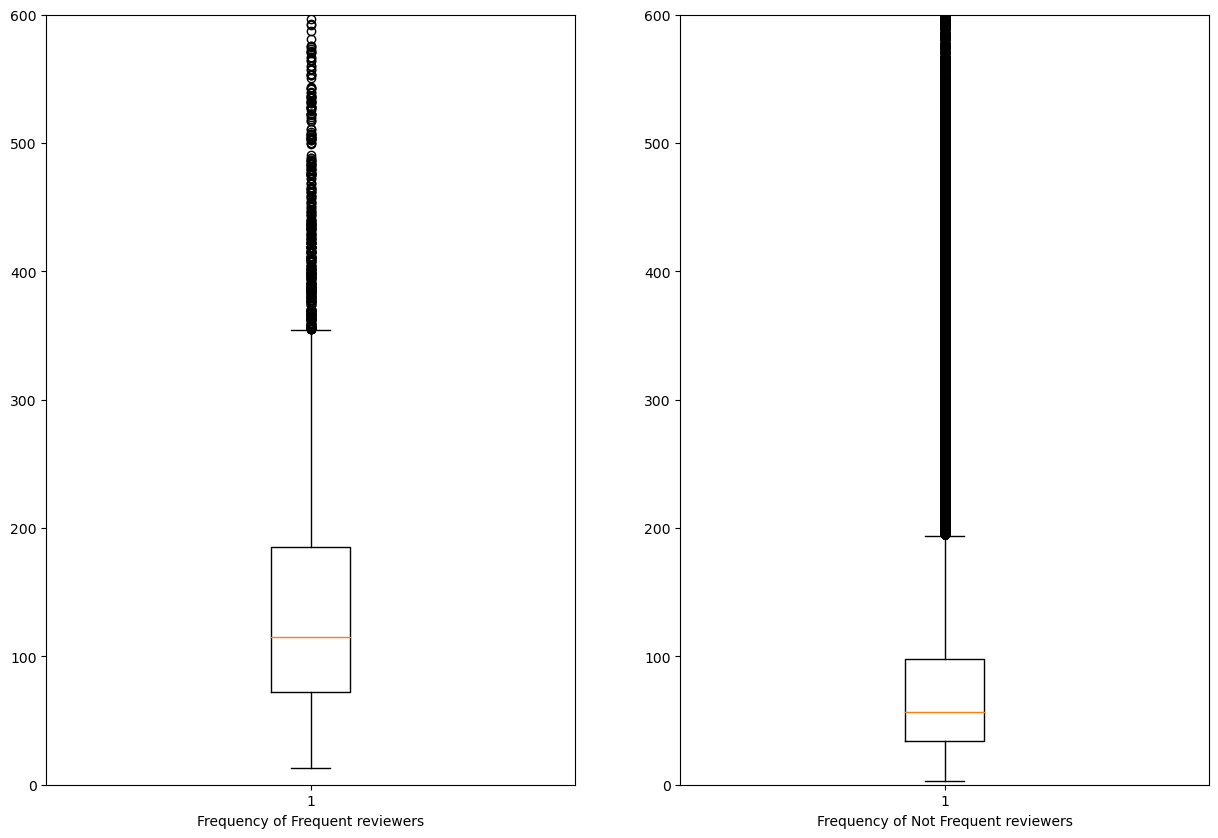

In [85]:
fig = plt.figure(figsize=(15,10))

ax1= fig.add_subplot(121)
ax1.boxplot(freq_data['Text_length'])
ax1.set_xlabel('Frequency of Frequent reviewers')
ax1.set_ylim(0,600)

ax2 = fig.add_subplot(122)
ax2.boxplot(not_freq_data['Text_length'])
ax2.set_xlabel('Frequency of Not Frequent reviewers')
ax2.set_ylim(0,600)

#### Sentiment analysis 

In [86]:
from textblob import TextBlob

In [87]:
new_valid['Summary'][0]

'Good Quality Dog Food'

In [90]:
TextBlob('Good Quality Dog Food').sentiment.polarity

0.7

In [91]:
sample_data = new_valid[0:50000]

In [93]:
polarity = []
for text in sample_data['Summary']:
    try:
        polarity.append(TextBlob(text).sentiment.polarity)
    except:
        polarity.append(0)

In [94]:
len(polarity)

50000

In [95]:
sample_data['polarity'] = polarity

In [96]:
sample_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,viewer_type,Text_length,polarity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,Not Frequent,49,0.7
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Frequent,31,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,Not Frequent,99,0.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,Not Frequent,43,0.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,Not Frequent,30,0.8


In [97]:
sample_neg = sample_data[sample_data['polarity'] < 0]
sample_pos = sample_data[sample_data['polarity'] > 0]

In [99]:
from collections import Counter

In [100]:
Counter(sample_neg['Summary']).most_common(10)

[('Disappointed', 44),
 ('Disappointing', 32),
 ('Bland', 18),
 ('Awful', 17),
 ('Not what I expected', 17),
 ('Terrible', 15),
 ('Horrible', 15),
 ('disappointed', 15),
 ('Disgusting', 12),
 ('not good', 11)]

In [101]:
Counter(sample_pos['Summary']).most_common(10)

[('Delicious!', 208),
 ('Delicious', 204),
 ('Great product', 100),
 ('Excellent', 85),
 ('Love it!', 81),
 ('Great', 81),
 ('Great Product', 77),
 ('Great!', 70),
 ('Good stuff', 51),
 ('Awesome', 50)]

In [106]:
neg_count = Counter(sample_neg['Summary']).most_common(10)
neg_count = pd.DataFrame(neg_count)
neg_count

,0,1
0,Disappointed,44
1,Disappointing,32
2,Bland,18
3,Awful,17
4,Not what I expected,17
5,Terrible,15
6,Horrible,15
7,disappointed,15
8,Disgusting,12
9,not good,11


In [107]:
neg_count.columns=['Keyword','Count']

In [108]:
neg_count

,Keyword,Count
0,Disappointed,44
1,Disappointing,32
2,Bland,18
3,Awful,17
4,Not what I expected,17
5,Terrible,15
6,Horrible,15
7,disappointed,15
8,Disgusting,12
9,not good,11


In [109]:
pos_count = Counter(sample_pos['Summary']).most_common(10)
pos_count = pd.DataFrame(pos_count)
pos_count.columns=['Keyword','Count']
pos_count

,Keyword,Count
0,Delicious!,208
1,Delicious,204
2,Great product,100
3,Excellent,85
4,Love it!,81
5,Great,81
6,Great Product,77
7,Great!,70
8,Good stuff,51
9,Awesome,50


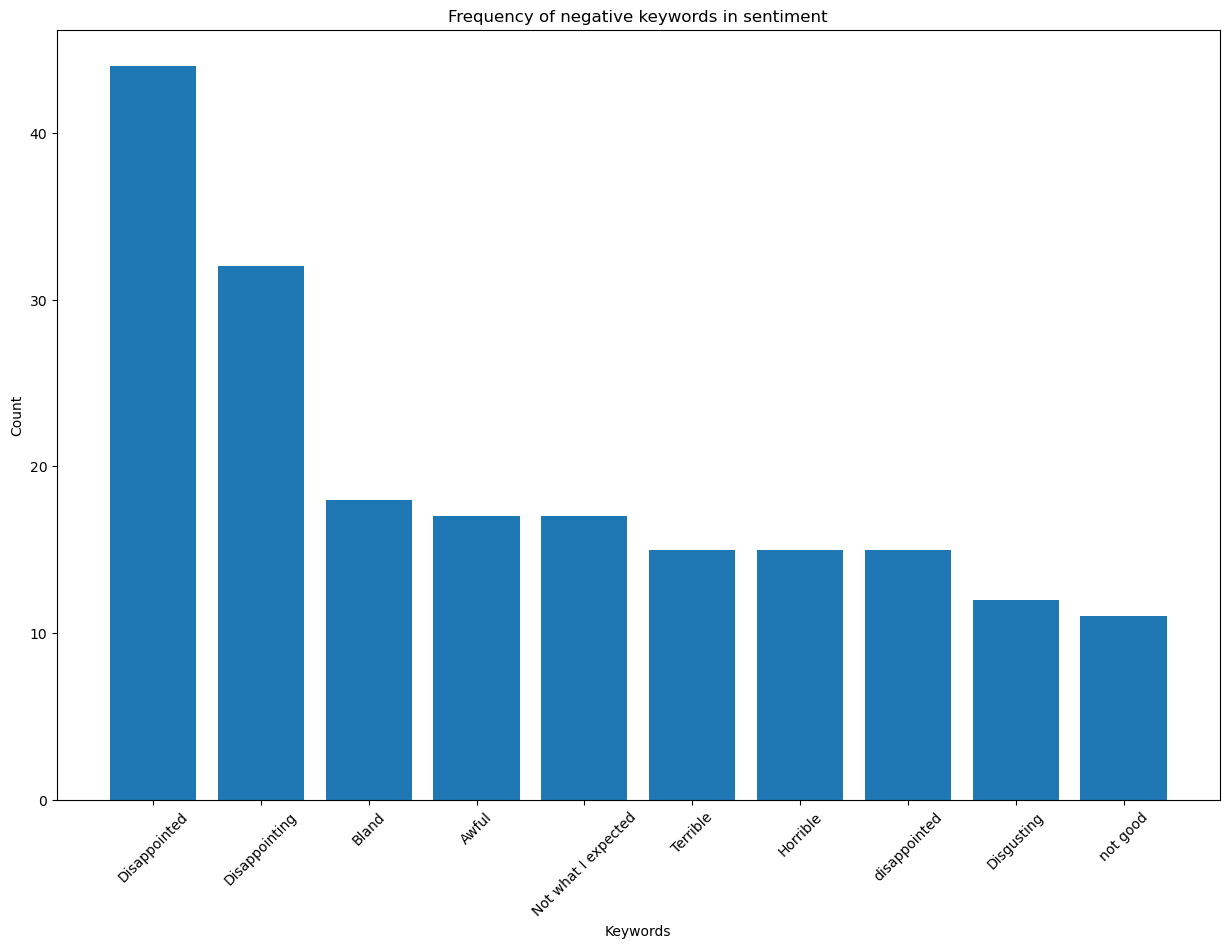

In [115]:
plt.figure(figsize=(15,10))

plt.bar(neg_count['Keyword'], neg_count['Count'])
plt.title("Frequency of negative keywords in sentiment")
plt.xlabel("Keywords")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

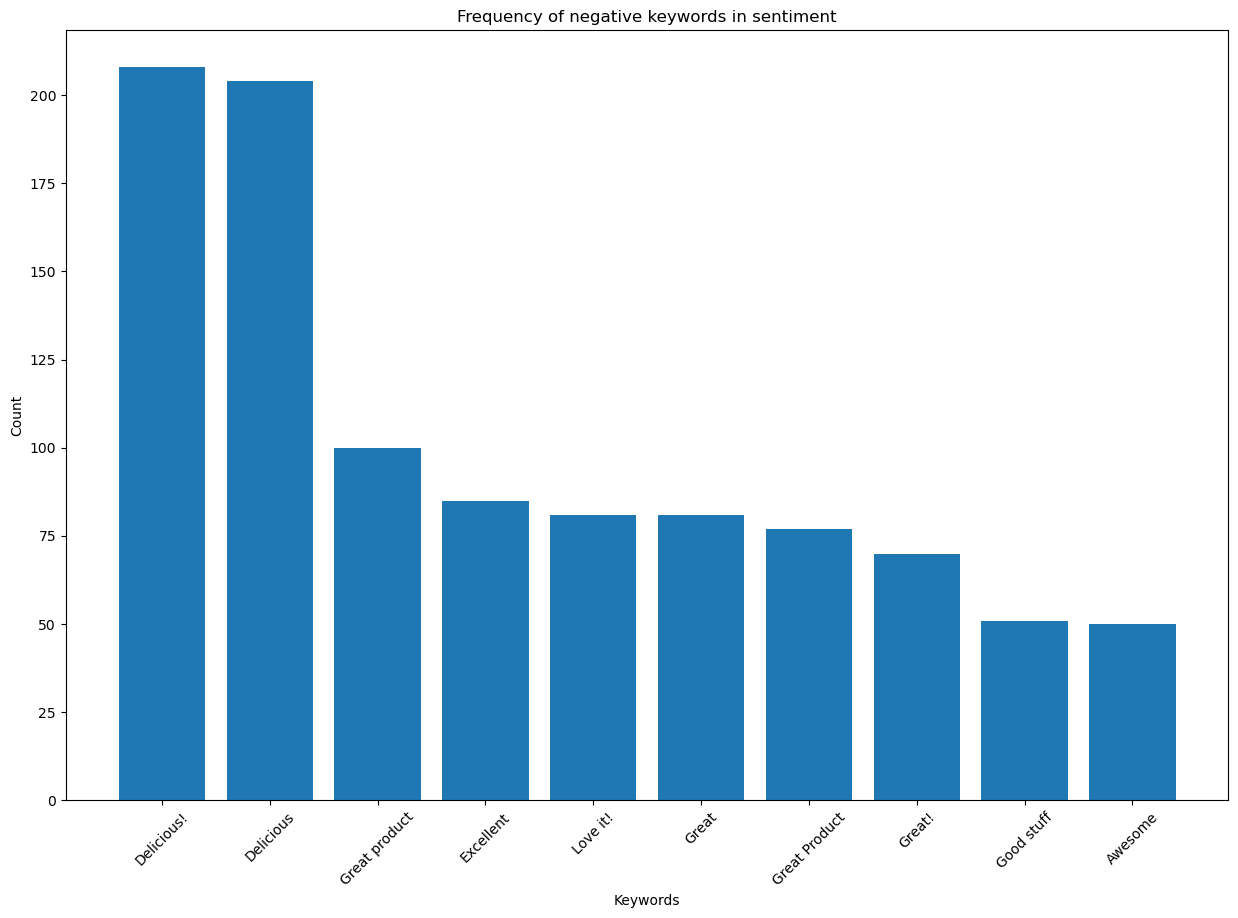

In [116]:
plt.figure(figsize=(15,10))

plt.bar(pos_count['Keyword'], pos_count['Count'])
plt.title("Frequency of negative keywords in sentiment")
plt.xlabel("Keywords")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()